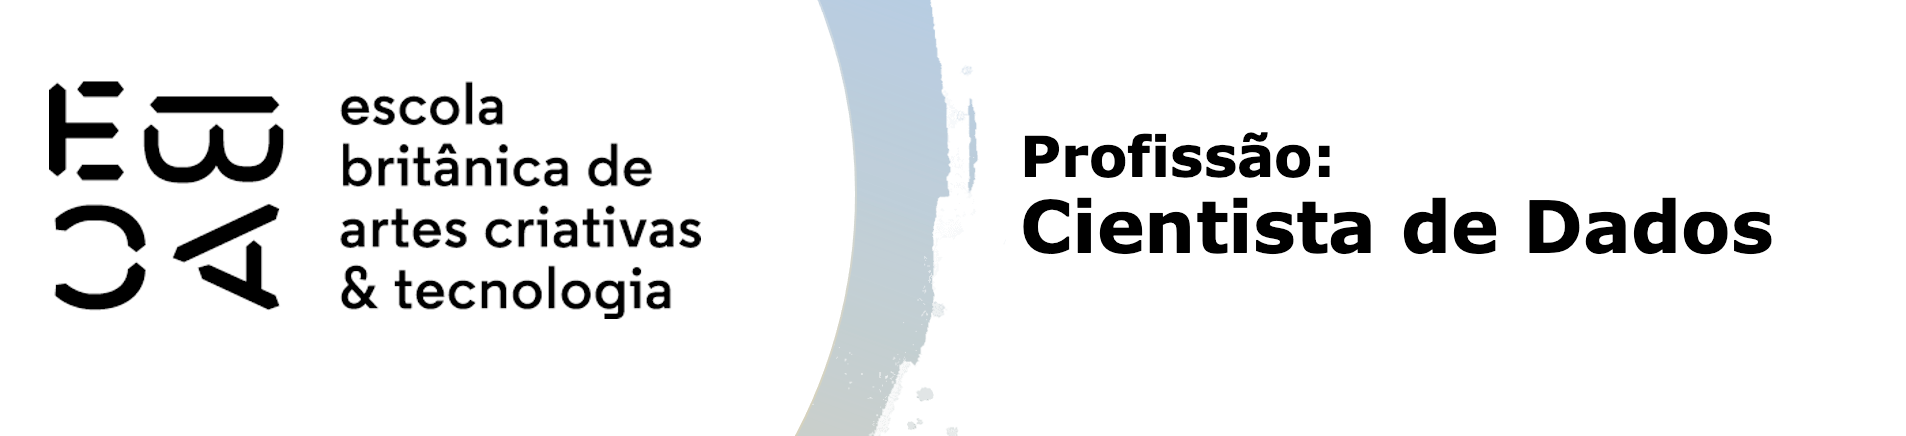

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

In [2]:
dados = pd.read_pickle('base_nfp.pkl')
dados.head(5)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [3]:
display(dados.isna().sum())

CNPJ emit.               0
Emitente                 0
No.                      0
Data Emissão             0
Valor NF                 0
Data Registro            0
Créditos                 0
Situação do Crédito      0
Ano                      0
Semestre                 0
Retorno                980
flag_credito             0
categoria                0
dtype: int64

In [4]:
dados['Retorno'].fillna(0,inplace=True)

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [6]:
ama = dados[(dados['Data Emissão']>='2020-01-01')].copy()
X_columns=ama.columns.tolist()
X_columns = [s.replace(' ', '_') for s in X_columns]
ama = ama.rename(columns=dict(zip(ama.columns, X_columns)))
ama.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86956 entries, 64598 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CNPJ_emit.           86956 non-null  object        
 1   Emitente             86956 non-null  object        
 2   No.                  86956 non-null  int64         
 3   Data_Emissão         86956 non-null  datetime64[ns]
 4   Valor_NF             86956 non-null  float64       
 5   Data_Registro        86956 non-null  datetime64[ns]
 6   Créditos             86956 non-null  float64       
 7   Situação_do_Crédito  86956 non-null  category      
 8   Ano                  86956 non-null  int64         
 9   Semestre             86956 non-null  int64         
 10  Retorno              86956 non-null  float64       
 11  flag_credito         86956 non-null  int64         
 12  categoria            86956 non-null  object        
dtypes: category(1), datetime64

In [7]:
ama[['Data_Emissão','Data_Registro']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86956 entries, 64598 to 187645
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Data_Emissão   86956 non-null  datetime64[ns]
 1   Data_Registro  86956 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.0 MB


In [8]:
dia_semana_num = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
ama['dia_da_semana'] = ama['Data_Emissão'].apply(lambda x: x.strftime('%a')).map(dia_semana_num)
# ama['dia_da_semana'] = ama['Data_Emissão'].apply(lambda x: x.strftime('%a'))
ama['fim_semana'] = ama['Data_Emissão'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
ama['dia_do_mes'] = ama['Data_Emissão'].apply(lambda x: x.strftime('%d')).astype(int)
ama['mes'] = ama['Data_Emissão'].apply(lambda x: x.strftime('%m')).astype(int)
ama['trim'] = ama['Data_Emissão'].apply(lambda x: '{}'.format((x.month-1)//3+1)).astype(int)
ama.groupby(['Ano','trim','mes','Data_Emissão','dia_do_mes','dia_da_semana','fim_semana']).agg({'Retorno': 'sum'})

Retorno
Ano  trim mes Data_Emissão dia_do_mes dia_da_semana fim_semana           
2019 1    1   2020-01-01   1          3             0            0.000000
2020 1    1   2020-01-01   1          3             0            5.010232
              2020-01-02   2          4             0           22.208003
              2020-01-03   3          5             0           17.174487
              2020-01-04   4          6             1           12.568183
...                                                                   ...
2021 4    12  2021-12-27   27         1             0           15.524335
              2021-12-28   28         2             0           22.424022
              2021-12-29   29         3             0           17.157118
              2021-12-30   30         4             0           11.799643
              2021-12-31   31         5             0            5.626872

[732 rows x 1 columns]

In [9]:
# Criando categorizações da variável Valor NF
ama['vr_nf5'] = pd.qcut(ama['Valor_NF'], q=5, labels=False)
ama['vr_nf10'] = pd.qcut(ama['Valor_NF'], q=10, labels=False)
ama['vr_nf20'] = pd.qcut(ama['Valor_NF'], q=20, labels=False)
ama['vr_nf50'] = pd.qcut(ama['Valor_NF'], q=50, labels=False)


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [10]:
df_ama=ama.copy()
ama.drop(columns=[#'categoria','dia_da_semana','dia_do_mes','mes',
                  'CNPJ_emit.', 'Emitente', 'No.', 'Data_Registro','Situação_do_Crédito'], inplace=True)
ama

,Data_Emissão,Valor_NF,Créditos,Ano,Semestre,Retorno,flag_credito,categoria,dia_da_semana,fim_semana,dia_do_mes,mes,trim,vr_nf5,vr_nf10,vr_nf20,vr_nf50
64598,2020-01-01,78.80,0.0,2019,2,0.0,0,não definido,3,0,1,1,1,2,5,11,27
64599,2020-01-01,22.71,0.0,2019,2,0.0,0,Mercado,3,0,1,1,1,0,1,3,9
64600,2020-01-01,35.90,0.0,2019,2,0.0,0,Alimentos,3,0,1,1,1,1,3,6,15
64601,2020-01-01,21.77,0.0,2019,2,0.0,0,Farmácia,3,0,1,1,1,0,1,3,8
64602,2020-01-01,80.95,0.0,2019,2,0.0,0,Restaurantes,3,0,1,1,1,2,5,11,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,2021-01-07,252.84,0.0,2021,2,0.0,0,não definido,4,0,7,1,1,4,8,17,42
187642,2021-01-07,373.65,0.0,2021,2,0.0,0,Mercado,4,0,7,1,1,4,9,18,45
187643,2021-01-07,130.71,0.0,2021,2,0.0,0,Farmácia,4,0,7,1,1,3,7,14,35
187644,2021-01-07,43.16,0.0,2021,2,0.0,0,Mercado,4,0,7,1,1,1,3,7,18


In [11]:
var_dummies=ama.select_dtypes(include='object').columns.tolist()
dummies = pd.get_dummies(ama[var_dummies])
categoria=ama.categoria
ama.drop(columns=var_dummies, inplace=True)
ama = pd.concat([ama, dummies], axis=1)


In [12]:
metadados = pd.DataFrame({'dtype':ama.dtypes})
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = ama.nunique()
display(metadados)

,dtype,papel,nunique
Data_Emissão,datetime64[ns],covariavel,731
Valor_NF,float64,covariavel,28381
Créditos,float64,covariavel,7845
Ano,int64,covariavel,3
Semestre,int64,covariavel,2
Retorno,float64,covariavel,35839
flag_credito,int64,resposta,2
dia_da_semana,int64,covariavel,7
fim_semana,int64,covariavel,2
dia_do_mes,int32,covariavel,31


In [13]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[1]
    rótulo_nao_evento = tab.columns[0]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]

    # verifica se há valores infinitos na coluna 'pct_nao_evento' e substitui por NaN
    tab['pct_nao_evento'] = tab['pct_nao_evento'].apply(lambda x: np.nan if np.isinf(x) else x)

    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)

    # verifica se há valores infinitos na coluna 'woe' e substitui por NaN
    tab['woe'] = tab['woe'].apply(lambda x: np.nan if np.isinf(x) else x)

    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()


In [14]:
%%time
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>5):
        metadados.loc[var, 'IV'] = IV(pd.qcut(ama[var],5,duplicates='drop'), ama.flag_credito)
    else: 
        metadados.loc[var, 'IV'] = IV(ama[var], ama.flag_credito)
        
# Define a função que irá mapear os valores de IV para as categorias
def categoriza_iv(valor):
    if valor <= 0.02:
        return "Inútil"
    elif valor <= 0.1:
        return "Fraco"
    elif valor <= 0.3:
        return "Médio"
    elif valor <= 0.5:
        return "Forte"
    elif valor >0.5:
        return "Suspeito"
    else:
        return "Não se aplica"

# Aplica a função para criar a nova coluna
metadados['poder_preditivo'] = metadados['IV'].apply(categoriza_iv)

        
metadados.sort_values('IV',ascending=False)        

CPU times: total: 2.97 s
Wall time: 2.97 s


,dtype,papel,nunique,IV,poder_preditivo
Retorno,float64,covariavel,35839,2.506160,Suspeito
Créditos,float64,covariavel,7845,2.473650,Suspeito
categoria_Varejo,uint8,covariavel,2,0.111796,Médio
categoria_Alimentos,uint8,covariavel,2,0.066433,Fraco
categoria_Restaurantes,uint8,covariavel,2,0.045311,Fraco
vr_nf10,int64,covariavel,10,0.038990,Fraco
vr_nf5,int64,covariavel,5,0.038990,Fraco
vr_nf50,int64,covariavel,50,0.038990,Fraco
vr_nf20,int64,covariavel,20,0.038990,Fraco
Valor_NF,float64,covariavel,28381,0.038990,Fraco


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

### Conclusão

Analisando a tabela com os valores de IV, é possível observar que as variáveis "Crédito" e "Retorno" apresentam valores de IV muito altos, superiores a **0.5**, sugerindo  que essas variáveis têm uma forte relação com a variável alvo, que já está incluída no modelo através de outra variável. Nesse caso, a inclusão da variável "Crédito" e "Retorno" pode levar a um problema de superajuste no modelo, o que pode prejudicar a sua capacidade de generalização para novos dados.<br>
Apesar disso, a variável _categoria_Varejo_ apresentou um IV de 0.11, indicando uma relação forte com a variável resposta.<br>
As demais variáveis possuem valores de IV mais baixos, o que indica que podem não apresentar uma forte relação com a variável resposta.

Durante o desenvolvimento foi preciso fazer diversas alterações para que a função pudesse ser aplicada adequadamente. Uma dessas modificações foi a transformação da variável **categoria**, originalmente uma string, em uma variável categorica dummie. <br>
Essa abordagem pode levar à perda de informações, uma vez que o número de categorias em que uma variável contínua é dividida pode afetar a relação entre essa variável e o IV da Variável Independente, afetando a capacidade de detectar relações entre a variável contínua e o IV.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [15]:
#Criando as bases de dados
df = df_ama.copy()
df[['Valor_NF','trim','categoria','flag_credito']]

#notas por trimestre
notas_por_trim = df.groupby('trim')['Valor_NF'].count().reset_index(name='Nº de notas')

#notas por categoria
notas_categoria = df.groupby(['categoria', 'trim']).size().unstack(fill_value=0)

# proporção de notas com crédito por categoria e por período
pivot_table = df.pivot_table(index='categoria', columns='trim', values='flag_credito', aggfunc=['sum', 'count'])

# Calcular a proporção de notas com crédito por categoria para cada trimestre
proporcao = pivot_table['sum'] / pivot_table['count']


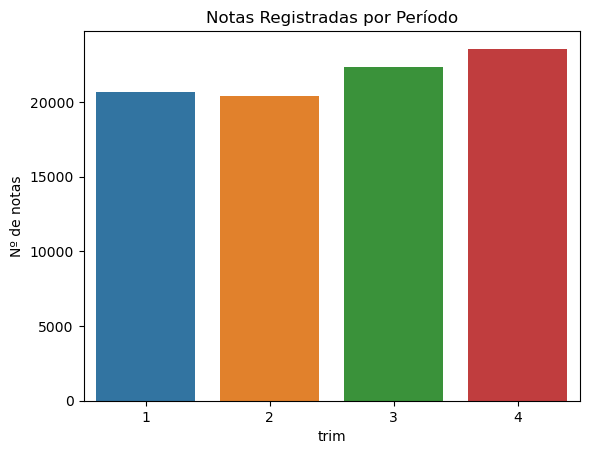

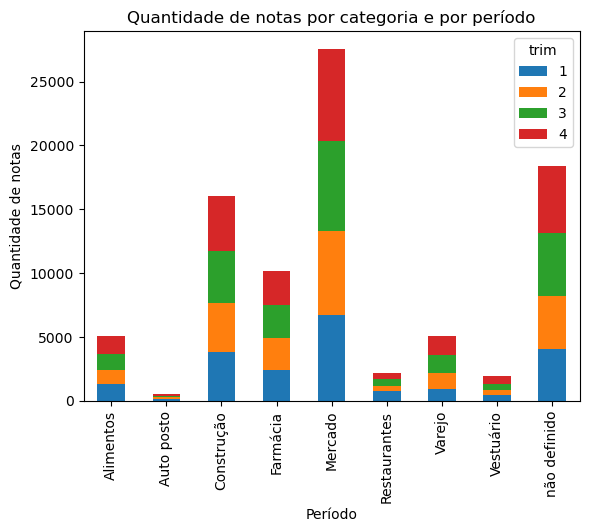

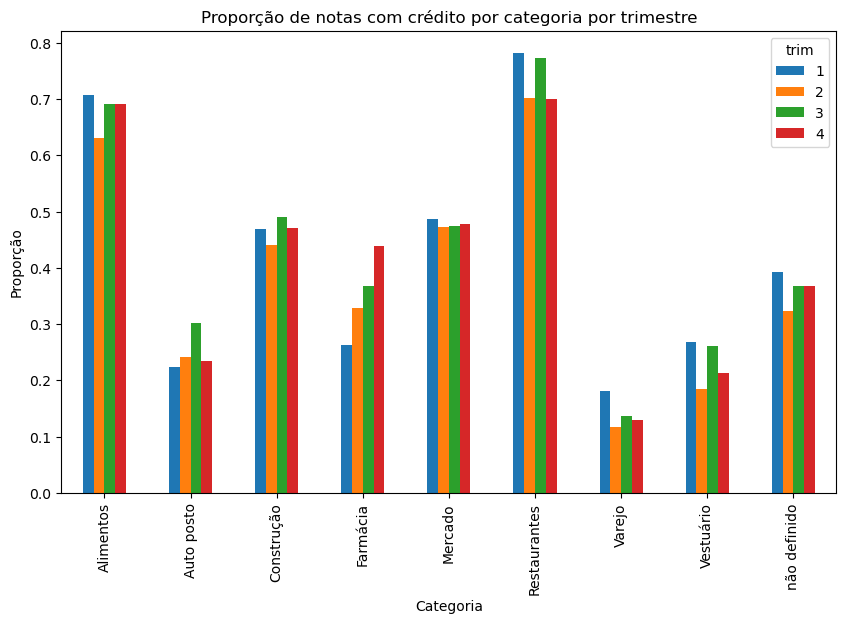

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: notas por período
notas_por_trim = df.groupby('trim')['Valor_NF'].count().reset_index(name='Nº de notas')
sns.barplot(x='trim', y='Nº de notas', data=notas_por_trim)
plt.title('Notas Registradas por Período')

# Gráfico 2: quantidade de notas por categoria e por período
fig, ax = plt.subplots()
notas_categoria.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Quantidade de notas por categoria e por período')
ax.set_xlabel('Período')
ax.set_ylabel('Quantidade de notas')

# Gráfico 3: proporção de notas com crédito por categoria por trimestre
fig, ax = plt.subplots(figsize=(10, 6))
proporcao.plot(kind='bar', ax=ax)
ax.set_title('Proporção de notas com crédito por categoria por trimestre')
ax.set_xlabel('Categoria')
ax.set_ylabel('Proporção')

# Exibindo os gráficos lado a lado
plt.subplots_adjust(wspace=0.4)
plt.show()


## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [115]:
df_wi=df_ama[['trim','categoria','Créditos','flag_credito']].copy()
dummies_flag = pd.get_dummies(df_wi['flag_credito'])
df_wi.drop(columns=['flag_credito'], inplace=True)
dummies_flag.rename(columns = {0:'não',1: 'sim'}, inplace = True)
df_wi = pd.concat([df_wi, dummies_flag], axis=1)
display(df_wi.tail(10))

# criar pivot_table com índice 'Data_Emissão' e 'categoria', e valores em 'flag_credito'
tab_wi = df_wi.pivot_table(index=['trim', 'categoria'], values=['sim','não'], aggfunc='sum')
display(tab_wi.head(15))

,trim,categoria,Créditos,não,sim
187636,1,Mercado,1.88,0,1
187637,1,Restaurantes,10.80,0,1
187638,1,Mercado,0.56,0,1
187639,1,Construção,0.00,1,0
187640,1,não definido,0.00,1,0
187641,1,não definido,0.00,1,0
187642,1,Mercado,0.00,1,0
187643,1,Farmácia,0.00,1,0
187644,1,Mercado,0.00,1,0
187645,1,Mercado,0.00,1,0


não   sim
trim categoria               
1    Alimentos      374   908
     Auto posto     118    34
     Construção    2043  1811
     Farmácia      1794   638
     Mercado       3456  3271
     Restaurantes   164   590
     Varejo         777   172
     Vestuário      314   115
     não definido  2481  1607
2    Alimentos      431   736
     Auto posto      88    28
     Construção    2126  1680
     Farmácia      1675   817
     Mercado       3453  3102
     Restaurantes   127   299

não   sim             N  tx_evento  pct_evento  \
trim categoria                                                       
1    Alimentos      374   908   6415.448001   0.141533    0.099278   
     Auto posto     118    34    757.487488   0.044885    0.003717   
     Construção    2043  1811  19272.442721   0.093968    0.198010   
     Farmácia      1794   638  12159.020996   0.052471    0.069757   
     Mercado       3456  3271  33638.543774   0.097240    0.357643   
     Restaurantes   164   590   3776.626830   0.156224    0.064509   
     Varejo         777   172   4741.991432   0.036272    0.018806   
     Vestuário      314   115   2143.391225   0.053653    0.012574   
     não definido  2481  1607  20441.405971   0.078615    0.175705   
2    Alimentos      431   736   5839.615927   0.126036    0.089418   
     Auto posto      88    28    578.280606   0.048419    0.003402   
     Construção    2126  1680  19032.535887   0.088270    0.204106   
     Farmácia      1675   817  12460.450141   0.065567    0.099259   
     Mercado       3453  3102  32778.897918   0.094634    0.376868   
     Restaurantes   127   299   2135.439492   0.140018    0.036326   
     Varejo        1118   148   6326.041073   0.023395    0.017981   
     Vestuário      347    79   2127.295412   0.037136    0.009598   
     não definido  2802  1342  20720.888287   0.064766    0.163042   
3    Alimentos      378   849   6140.187605   0.138269    0.087346   
     Auto posto      95    41    678.930903   0.060389    0.004218   
     Construção    2075  2004  20397.842021   0.098246    0.206173   
     Farmácia      1626   943  12845.617842   0.073410    0.097016   
     Mercado       3723  3370  35468.424047   0.095014    0.346708   
     Restaurantes   116   397   2571.376629   0.154392    0.040844   
     Varejo        1156   184   6696.231031   0.027478    0.018930   
     Vestuário      337   119   2278.354335   0.052231    0.012243   
     não definido  3112  1813  24626.278708   0.073621    0.186523   
4    Alimentos      425   949   6875.215436   0.138032    0.092848   
     Auto posto     104    32    677.797135   0.047212    0.003131   
     Construção    2280  2028  21542.546995   0.094139    0.198415   
     Farmácia      1512  1184  13481.666360   0.087823    0.115840   
     Mercado       3749  3434  35918.410610   0.095606    0.335975   
     Restaurantes   146   340   2434.996750   0.139631    0.033265   
     Varejo        1314   197   7551.117590   0.026089    0.019274   
     Vestuário      479   130   3042.547676   0.042727    0.012719   
     não definido  3323  1927  26251.291326   0.073406    0.188533   

                   pct_nao_evento       WOE  iv_parcial  
trim categoria                                           
1    Alimentos           0.032462  1.117843    0.074690  
     Auto posto          0.010242 -1.013469    0.006613  
     Construção          0.177328  0.110315    0.002281  
     Farmácia            0.155716 -0.803010    0.069025  
     Mercado             0.299974  0.175839    0.010140  
     Restaurantes        0.014235  1.511111    0.075970  
     Varejo              0.067442 -1.277091    0.062113  
     Vestuário           0.027255 -0.773606    0.011357  
     não definido        0.215346 -0.203438    0.008064  
2    Alimentos           0.035424  0.925942    0.049996  
     Auto posto          0.007233 -0.754312    0.002890  
     Construção          0.174735  0.155371    0.004563  
     Farmácia            0.137667 -0.327109    0.012564  
     Mercado             0.283800  0.283624    0.026396  
     Restaurantes        0.010438  1.247076    0.032284  
     Varejo              0.091888 -1.631265    0.120562  
     Vestuário           0.028520 -1.089057    0.020607  
     não definido        0.230295 -0.345353    0.023226  
3    Alimentos           0.029957  1.070104    0.061412  
     Auto posto          0.007529 -0.579366    0.001918  
     Construção          0.164448  0.226123    0.009435  
     Farmácia            

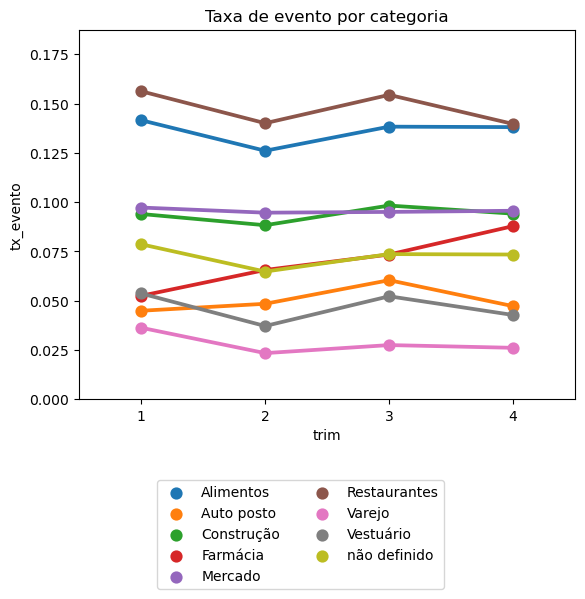

In [154]:
tab_wi['N'] = tab_wi.sum(axis=1)
tab_wi['tx_evento'] = tab_wi.sim/tab_wi.N
tab_wi.reset_index()
display(tab_wi)

fig, ax = plt.subplots()

sns.pointplot(data=tab_wi.reset_index(), x='trim', y='tx_evento', hue='categoria', ci=None, ax=ax)
ax.set_ylim([0, tab_wi.tx_evento.max()*1.2]);
ax.set_title(f'Taxa de evento por categoria')
ax.legend(bbox_to_anchor=(.75, -.2), ncol=2);

não   sim             N  tx_evento  pct_evento  \
trim categoria                                                     
1    Alimentos    374   908   2564.708268   0.354036    0.099278   
     Auto posto   118    34    304.223684   0.111760    0.003717   
     Construção  2043  1811   7708.469901   0.234936    0.198010   
     Farmácia    1794   638   4864.262336   0.131161    0.069757   
     Mercado     3456  3271  13454.486249   0.243116    0.357643   

                 pct_nao_evento       WOE  iv_parcial  
trim categoria                                         
1    Alimentos         0.032462  1.117843    0.074690  
     Auto posto        0.010242 -1.013469    0.006613  
     Construção        0.177328  0.110315    0.002281  
     Farmácia          0.155716 -0.803010    0.069025  
     Mercado           0.299974  0.175839    0.010140

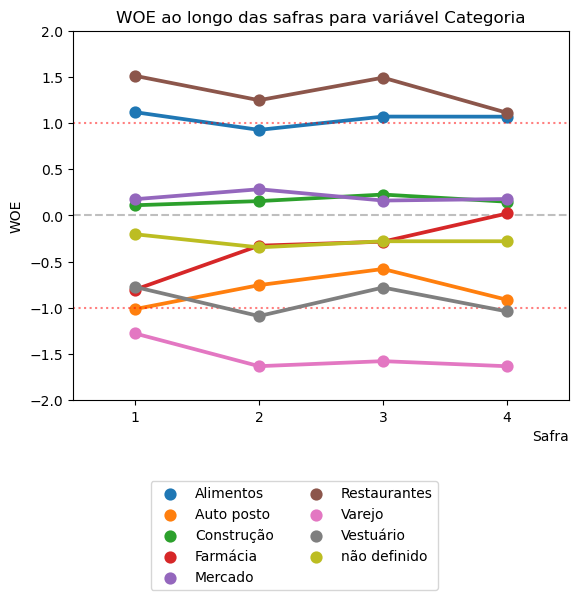

In [135]:
rotulo_ev, rotulo_nev = ('sim', 'não')

tab_wi['pct_evento']     = tab_wi[rotulo_ev]/tab_wi[rotulo_ev].groupby(level=0).sum()
tab_wi['pct_nao_evento'] = tab_wi[rotulo_nev]/tab_wi[rotulo_nev].groupby(level=0).sum()
tab_wi['WOE'] = np.log(tab_wi.pct_evento/tab_wi.pct_nao_evento)
tab_wi['iv_parcial'] = (tab_wi.pct_evento - tab_wi.pct_nao_evento)*tab_wi.WOE
display(tab_wi.head())

fig, ax = plt.subplots()
variavel='categoria'

# Comando principal do gráfico
sns.pointplot(data=tab_wi.reset_index(), y = 'WOE', x = 'trim', hue=variavel, ax=ax);

# Rotacionar os rótulos do eixo X
labs = tab_wi.index.get_level_values(level=0).unique()
ax.legend(bbox_to_anchor=(.75, -.2), ncol=2)

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(2, max(tab_wi.WOE))
ymin = min(-2, min(tab_wi.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo das safras para variável {variavel.capitalize()}')
ax.set_xlabel('Safra', loc='right');

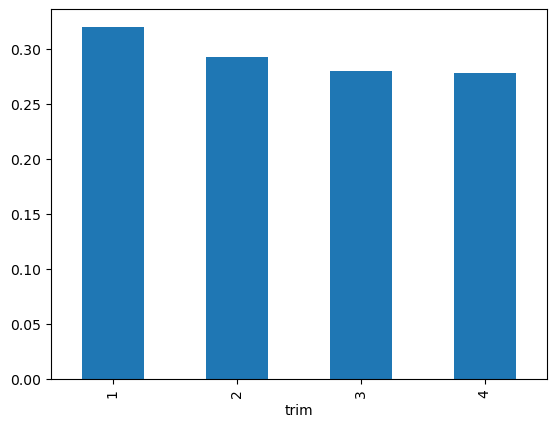

In [122]:
iv_categoria = ((tab_wi.pct_evento - tab_wi.pct_nao_evento)*tab_wi.WOE).groupby(level=0).sum()
iv_categoria.plot.bar();

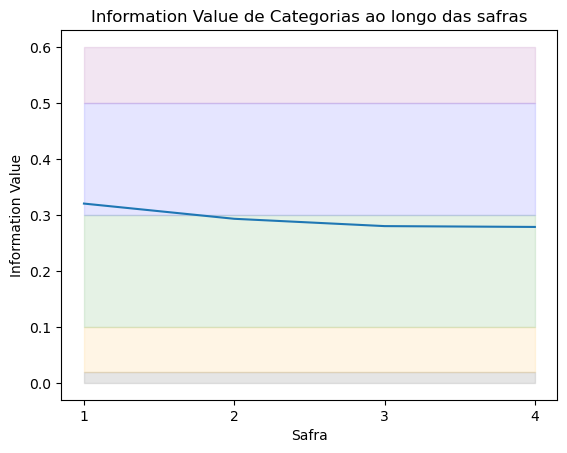

In [123]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    labs = IV.index.get_level_values(level=0).unique()
#     labs2 = [x.to_period('M') for x in labs]

    ax.set_xticks(labs)
#     ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de Categorias ao longo das safras")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Safra")

plot_iv(iv_categoria)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

### Conclusão
Com base na análise dos dados, pode-se concluir que os setores de **Restaurante** e **Alimentos** apresentam as maiores taxas de retorno de valores de notas com tx_evento maiores que zero.<br> Entretanto, destaca-se que a categoria **Farmácia** apresentou um forte crescimento ao longo do período analisado e, portanto, não deve ser negligenciada em futuras análises.
